In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'advertisingcsv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F582088%2F1052144%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T140857Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dadd0eff4dac036c5865d7c81aaad64d831d4fbcdc4623873b868e102725d32d8510683c26cada597b734074521ddd8540aef9431cd3e8c8a1371430a694a1d62ed736ba942a28cebf929857f42aa7c1bf0308073a22d8d0977bd18920b41c2304c2cfe16fa16a26e61b7eceb4aa8da0dee13ca14aa7eeb8bc07c6fb5be03ea85585b876bf0cda89bd40279a597a32a344782162487a8f5707d5df3f9d0c2204bbc72b9df71b57fd8f58a5bc16a33326b2b0699abcac48362a58e4cd9672b8fde6bce41b8dc090b58cfafff24de2528af38f4d0b510b32340ca7fc61b0c7ccce020046d5c1cb4b1b7b16aaec081546d2f8d4690f0af8ab5971142cb4c956810e4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2316 bytes downloaded
Downloaded and uncompressed: advertisingcsv
Data source import complete.


# Importing Libraries

In [ ]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

# data manipulation
import pandas as pd

# data visulization
import matplotlib.pyplot as plt
import seaborn as sns

# model building
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingRegressor

# Load Data

In [ ]:
# load data
data = pd.read_csv('/kaggle/input/advertisingcsv/Advertising.csv')
data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [ ]:
# drop unnecessary col
data = data.drop(columns=['Unnamed: 0'])

In [ ]:
# info about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [ ]:
# statistics of data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


In [ ]:
# check null values
data.isna().sum()

,0
TV,0
Radio,0
Newspaper,0
Sales,0


In [ ]:
# check duplicates values
data.duplicated().sum()

0

# EDA

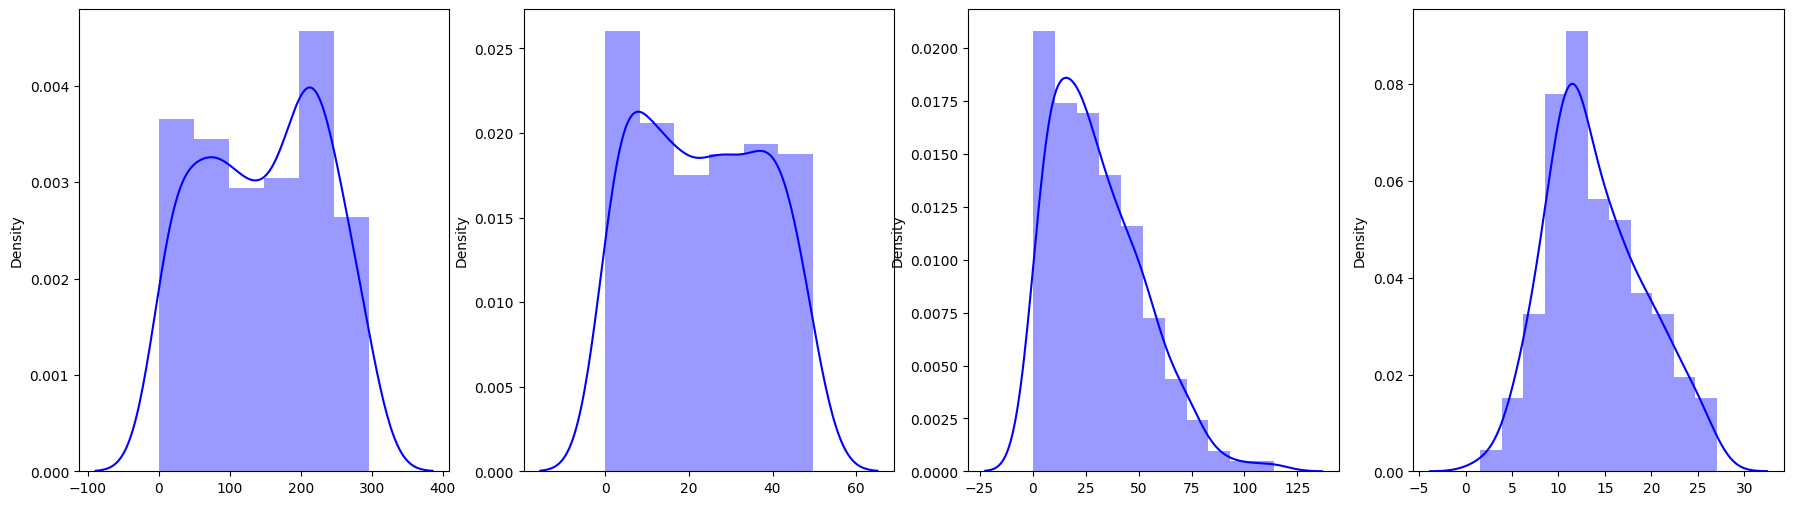

In [ ]:
# Dist plot of each cols
fig,axes = plt.subplots(1,4,figsize=(22,6))

sns.distplot(ax=axes[0],x=data['TV'],color='blue')
sns.distplot(ax=axes[1],x=data['Radio'],color='blue')
sns.distplot(ax=axes[2],x=data['Newspaper'],color='blue')
sns.distplot(ax=axes[3],x=data['Sales'],color='blue')
plt.show()


# Extract Target and Input cols

In [ ]:
# Extract target and input cols
features = data[['TV','Radio','Newspaper']]
target = data['Sales']

# Spliting the data

In [ ]:
# train test spliting
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160, 3) (40, 3) (160,) (40,)


# Scaling

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Model Building & Model Evaluation

In [ ]:
# linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(r2_score(y_test,y_pred))

0.899438024100912


In [ ]:
print(lr.coef_)
print(lr.intercept_)

[0.04472952 0.18919505 0.00276111]
2.979067338122629


In [ ]:
lr_sc = LinearRegression()
lr_sc.fit(X_train_sc,y_train)
lr_sc_pred = lr_sc.predict(X_test_sc)
print(r2_score(y_test,lr_sc_pred))

0.8994380241009119
